Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [ ]:
!pip install git+https://github.com/huggingface/datasets#egg=datasets
! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Fine-tuning the model** (20 points)

In [ ]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel,
                          trainer, training_args)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric
from tqdm.auto import tqdm
import numpy as np

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [ ]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [ ]:
model = ElectraForMaskedLM.from_pretrained(MODEL_NAME)
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
pipe = pipeline('fill-mask', model=model, tokenizer=tokenizer)
result_1 = pipe('Why don\'t you ask [MASK]?')
result_2 = pipe('What is [MASK]')
result_3 = pipe('Let\'s talk about [MASK] physics')
print(result_1[0])
print(result_2[0])
print(result_3[0])

{'score': 0.5342992544174194, 'token': 2033, 'token_str': 'm e', 'sequence': "why don't you ask me?"}
{'score': 0.9262322783470154, 'token': 1029, 'token_str': '?', 'sequence': 'what is?'}
{'score': 0.24027501046657562, 'token': 8559, 'token_str': 'q u a n t u m', 'sequence': "let's talk about quantum physics"}


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True, return_tensors='pt')

tokenized_datasets = dataset.map(tokenize_function)

  0%|          | 0/1400000 [00:00<?, ?ex/s]

  0%|          | 0/60000 [00:00<?, ?ex/s]

In [ ]:
#train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
#eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(5000))
train_dataset = tokenized_datasets["train"].select(range(5000))
eval_dataset = tokenized_datasets["test"].select(range(5000))

In [ ]:
print(np.shape(train_dataset))
print(np.shape(eval_dataset))

(5000, 8)
(5000, 8)


In [ ]:
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

In [ ]:
# training
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

losses = []

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        
        batch = {k: v for k, v in batch.items()}
        
        input_ids = torch.stack(batch["input_ids"][0]).t()
        attention_mask = torch.stack(batch['attention_mask'][0]).t()
        token_type_ids = torch.stack(batch['token_type_ids'][0]).t()

        #outputs = model(**input_ids)
        outputs = model.forward(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=batch['topic'])
        loss = outputs.loss
        losses.append(float(loss))
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1875 [00:00<?, ?it/s]

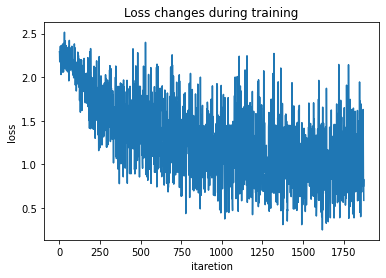

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
#plt.ylim([0.0, 0.6])
plt.title('Loss changes during training')
plt.xlabel('itaretion')
plt.ylabel('loss')
plt.show()

In [ ]:
f1_metric = load_metric("f1")

#def compute_f1(eval_pred):
#    logits, labels = eval_pred
#    predictions = np.argmax(logits, axis=-1)
#    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

model.eval()
for batch in eval_dataloader:
    batch = {k: v for k, v in batch.items()}
    with torch.no_grad():

        input_ids = torch.stack(batch["input_ids"][0]).t()
        attention_mask = torch.stack(batch['attention_mask'][0]).t()
        token_type_ids = torch.stack(batch['token_type_ids'][0]).t()

        outputs = model.forward(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=batch['topic'])

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    f1_metric.add_batch(predictions=predictions, references=batch["topic"])

f1_metric.compute(average="weighted")

{'f1': 0.556605787849644}

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.makedirs('/content/drive/My Drive/Elektra_fine-tuned')

model.save_pretrained('/content/drive/My Drive/Elektra_fine-tuned')

Mounted at /content/drive/


In [ ]:
model_2 = ElectraForMaskedLM.from_pretrained('/content/drive/My Drive/Elektra_fine-tuned')
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Some weights of the model checkpoint at /content/drive/My Drive/Elektra_fine-tuned were not used when initializing ElectraForMaskedLM: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /content/drive/My Drive/Elektra_fine-tuned and are newly initialized: ['generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.

In [ ]:
pipe = pipeline('fill-mask', model=model_2, tokenizer=tokenizer)
result_1 = pipe('Why don\'t you ask [MASK]?')
result_2 = pipe('What is [MASK]')
result_3 = pipe('Let\'s talk about [MASK] physics')
print(result_1[0])
print(result_2[0])
print(result_3[0])

{'score': 0.0005372777814045548, 'token': 24860, 'token_str': '# # g r i n', 'sequence': "why don't you askgrin?"}
{'score': 0.0003714176709763706, 'token': 21596, 'token_str': '# # v a t i o n', 'sequence': 'what isvation'}
{'score': 0.0003614156157709658, 'token': 22068, 'token_str': '# # a p a', 'sequence': "let's talk aboutapa physics"}


The result does not look very good, especially compared to what we got on a non-fine-tuned model. This result can be explained by the fact that during training we did not freeze the lower layers of the pretrained network. Let's try further to train only the top layer, which we added to the pre-trained network for classification.

In [ ]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_predictions.dense.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [ ]:
# freezing all the layers exept the ones for classification

for param in model.parameters():
      param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
# training

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

losses = []

model.classifier.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        
        batch = {k: v for k, v in batch.items()}
        
        input_ids = torch.stack(batch["input_ids"][0]).t().to(device)
        attention_mask = torch.stack(batch['attention_mask'][0]).t().to(device)
        token_type_ids = torch.stack(batch['token_type_ids'][0]).t().to(device)

        #outputs = model(**input_ids)
        outputs = model.forward(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=batch['topic'].to(device))
        
        loss = outputs.loss
        losses.append(float(loss.item()))
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.makedirs('/content/drive/My Drive/Elektra_fine-tuned-freezed')

model.save_pretrained('/content/drive/My Drive/Elektra_fine-tuned-freezed')

Mounted at /content/drive/


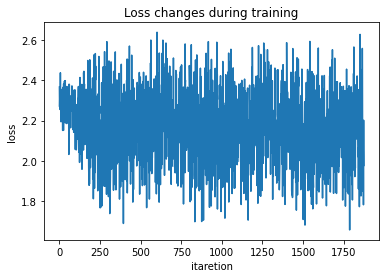

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
#plt.ylim([0.0, 0.6])
plt.title('Loss changes during training')
plt.xlabel('itaretion')
plt.ylabel('loss')
plt.show()

In [ ]:
f1_metric = load_metric("f1")

model.eval()
for batch in eval_dataloader:
    batch = {k: v for k, v in batch.items()}
    with torch.no_grad():

        input_ids = torch.stack(batch["input_ids"][0]).t().to(device)
        attention_mask = torch.stack(batch['attention_mask'][0]).t().to(device)
        token_type_ids = torch.stack(batch['token_type_ids'][0]).t().to(device)

        outputs = model.forward(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=batch['topic'].to(device))

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    f1_metric.add_batch(predictions=predictions, references=batch["topic"])

f1_metric.compute(average="weighted")

{'f1': 0.09318310222508867}

In [ ]:
model_3 = ElectraForMaskedLM.from_pretrained('/content/drive/My Drive/Elektra_fine-tuned-freezed')
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Some weights of the model checkpoint at /content/drive/My Drive/Elektra_fine-tuned-freezed were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /content/drive/My Drive/Elektra_fine-tuned-freezed and are newly initialized: ['generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.weight', '

In [ ]:
pipe = pipeline('fill-mask', model=model_3, tokenizer=tokenizer)
result_1 = pipe('Why don\'t you ask [MASK]?')
result_2 = pipe('What is [MASK]')
result_3 = pipe('Let\'s talk about [MASK] physics')
print(result_1[0])
print(result_2[0])
print(result_3[0])

{'score': 0.00034294111537747085, 'token': 9175, 'token_str': 's o x', 'sequence': "why don't you ask sox?"}
{'score': 0.0004136147035751492, 'token': 10524, 'token_str': '# # r o w', 'sequence': 'what isrow'}
{'score': 0.0004722410812973976, 'token': 16016, 'token_str': 'p u l p', 'sequence': "let's talk about pulp physics"}


We see here, that result is not quite good. It's so due to the fact, that the network didn't really learn during training process, as we can see from loss graph above